## Stack - Projeto Human Resources Analytics

### Machine Learning.

In [1]:
# Estrutura de dados e operações matemáticas.
import pandas as pd
import numpy as np

# Operações com objetos temporais.
import datetime

# Leitura de arquivos.
import glob

# Conexão com o datalake.
from minio import Minio

# Visualização.
import matplotlib.pyplot as plt

# Filtrando avisos.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Instanciando cliente que fará conexão com o datalake.
client = Minio(
    "localhost:9000",         # IP e porta do datalake.
    access_key="minioadmin",  # Usuário.
    secret_key="minioadmin",  # Senha.
    secure=False              # Desabilitando conexão segura.
)

### Baixando o Dataset do Data Lake.

In [3]:
# Recuperando dataset completo do datalake.
client.fget_object(
    "processing",                 # Nome do bucket.
    "employees_dataset.parquet",  # Nome do arquivo.
    "temp_.parquet",              # Nome da cópia local que será feita do arquivo.
)

# Lendo o dataset local.
df = pd.read_parquet("temp_.parquet")

df.head()

,department,salary,left,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,0.0
1,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,0.0
2,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,0.0
3,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,0.0
4,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,0.0


#### Organizando o dataset.

In [4]:
df = df[['department', 'salary', 'mean_work_last_3_months', 'number_projects', 
         'satisfaction_level', 'last_evaluation', 'time_in_company', 'work_accident','left']]

df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0


#### Verificando valores nulos.

In [5]:
# Há um valor nulo.
df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [6]:
# Excluindo esse registro nulo.
df.dropna(inplace=True)

In [7]:
df.isnull().sum().sum()

0

#### Convertendo atributos para o tipo inteiro.

In [8]:
df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   department               14999 non-null  object 
 1   salary                   14999 non-null  object 
 2   mean_work_last_3_months  14999 non-null  int32  
 3   number_projects          14999 non-null  int32  
 4   satisfaction_level       14999 non-null  float64
 5   last_evaluation          14999 non-null  float64
 6   time_in_company          14999 non-null  int32  
 7   work_accident            14999 non-null  int32  
 8   left                     14999 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 878.8+ KB


#### Renomeando atributos.

In [10]:
df.rename(columns={'satisfaction_level': 'satisfaction', 
                   'last_evaluation': 'evaluation',
                   'number_projects': 'projectCount',
                   'mean_work_last_3_months': 'averageMonthlyHours',
                   'time_in_company': 'yearsAtCompany',
                   'work_accident': 'workAccident',
                   'left' : 'turnover'
                  }, inplace=True)

df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


## Pré-processamento

#### Converte os atributos categóricos para valores numéricos.

In [11]:
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,7,1,266,2,38.0,53.0,3,0,1
1,7,2,252,5,80.0,86.0,6,0,1
2,7,2,289,7,11.0,88.0,4,0,1
3,7,1,275,5,72.0,87.0,5,0,1
4,7,1,292,2,37.0,52.0,3,0,1


#### Separando os conjuntos de dados.

In [12]:
target_name = 'turnover'
X = df.drop(target_name, axis=1)
y = df[target_name]

#### Transformando os dados.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [15]:
X

array([[0.77777778, 0.5       , 0.38202247, ..., 0.265625  , 0.125     ,
        0.        ],
       [0.77777778, 1.        , 0.2247191 , ..., 0.78125   , 0.5       ,
        0.        ],
       [0.77777778, 1.        , 0.64044944, ..., 0.8125    , 0.25      ,
        0.        ],
       ...,
       [1.        , 1.        , 0.62921348, ..., 0.265625  , 0.125     ,
        0.        ],
       [0.88888889, 0.5       , 0.4494382 , ..., 0.9375    , 0.25      ,
        0.        ],
       [0.88888889, 0.5       , 0.49438202, ..., 0.25      , 0.125     ,
        0.        ]])

### Separando os conjuntos de dados.

<img src="https://www.researchgate.net/profile/Brian-Mwandau/publication/325870973/figure/fig6/AS:639531594285060@1529487622235/Train-Test-Data-Split.png" align="left">

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Divindo os dados em 20% para teste (80% para treino) e estratificando pelo valor de y (turnover).
# A estratificação compensa o desbalanceio das classes e garante que a proporcionalidade do conjunto de
# dados total será mantida nos splits de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

#### Treinando o algoritmo de arvore de decisão.

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
# Instanciando modelo de Árvore de Decisão.
dtree = DecisionTreeClassifier()

# Treinando o modelo.
dtree = dtree.fit(X_train, y_train)

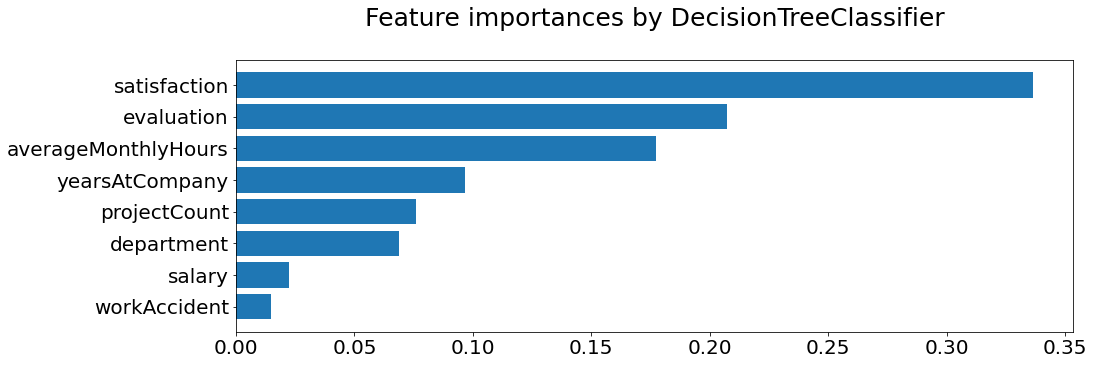

In [20]:
# Tamanho da plotagem.
plt.rcParams['figure.figsize'] = (15, 5)

# Tamanho das fontes.
plt.rcParams['axes.titlesize'] = 25   # Título.
plt.rcParams['xtick.labelsize'] = 20  # Valores em x.
plt.rcParams['ytick.labelsize'] = 20  # Valores em y.
plt.rcParams['axes.labelsize'] = 20   # Rótulos dos eixos.

# Importância de cada atributo treinado.
importances = dtree.feature_importances_

# Nome de cada atributo treinado.
feat_names = df.drop([target_name], axis=1).columns

# Ordenando índices com base no valor da importância.
indices = np.argsort(importances)

# Gerando gráfico de barras horizontal.
plt.barh(feat_names[indices], importances[indices], align="center")

# Título da plotagem.
plt.title("Feature importances by DecisionTreeClassifier\n")

plt.show()

#### Filtrando apenas os atributos relevantes.

In [21]:
X = df[["satisfaction", "evaluation", "averageMonthlyHours", "yearsAtCompany"]]

#### Separando os conjuntos de dados.

In [22]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [24]:
X_train

array([[0.59340659, 0.21875   , 0.40449438, 0.125     ],
       [0.        , 0.703125  , 0.41573034, 0.25      ],
       [0.9010989 , 0.34375   , 0.48314607, 0.125     ],
       ...,
       [0.2967033 , 0.234375  , 0.35955056, 0.125     ],
       [0.92307692, 0.28125   , 0.46067416, 0.        ],
       [0.51648352, 0.5       , 0.53932584, 0.125     ]])

#### Função do modelo de base.

In [25]:
# O nosso modelo de base sempre gera o mesmo output, 0 (sem turnover). Ele é a nossa referência e mostrará
# se todo o trabalho despendido na criação de outro modelo valeu o esforço, para isso precisaremos comparar
# as métricas do nosso modelo com o modelo base.
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y

#### Importando métodos de métrica de avaliação.

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [27]:
def accuracy_result(y_test, y_predict):
    acc = accuracy_score(y_test, y_predict)
    print("Accuracy = %2.2f" % acc)

In [28]:
def roc_classification_report_results(model, y_test, y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

#### Análise do modelo de base.

In [29]:
y_predict = base_rate_model(X_test)

In [30]:
accuracy_result(y_test, y_predict)

Accuracy = 0.76


In [31]:
roc_classification_report_results("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      2286
           1       0.00      0.00      0.00       714

    accuracy                           0.76      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.58      0.76      0.66      3000



### Modelo de Regressão Logística.

<img src="https://editor.analyticsvidhya.com/uploads/95588WhatsApp-Image-2020-02-11-at-8.30.11-PM.jpeg" align="left">

#### Instanciando o algoritmo.

In [32]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression()

#### Realizando o treinamento.

In [33]:
logis.fit(X_train, y_train)

LogisticRegression()

#### Calculando as predições.

In [34]:
y_predict = logis.predict(X_test)

#### Avaliando o resultado.

In [35]:
accuracy_result(y_test, y_predict)

Accuracy = 0.76


In [36]:
roc_classification_report_results("Logistic Regression", y_test, y_predict)


Logistic Regression AUC = 0.5333579626076153

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      2286
           1       0.52      0.09      0.16       714

    accuracy                           0.76      3000
   macro avg       0.65      0.53      0.51      3000
weighted avg       0.71      0.76      0.70      3000



### Modelo de Arvore de decisão.

<img src="https://www.devops.ae/wp-content/uploads/2021/04/decision-tree-classification-algorithm.png" align="left">

#### Instânciando o algoritmo.

In [37]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

#### Realizando o treinamento.

In [38]:
dtree = dtree.fit(X_train, y_train)

#### Calculando as predições.

In [39]:
y_predict = dtree.predict(X_test)

#### Avaliando o resultado.

In [40]:
accuracy_result(y_test, y_predict)

Accuracy = 0.74


In [41]:
roc_classification_report_results("Decision Tree", y_test, y_predict)


Decision Tree AUC = 0.6506521243668071

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2286
           1       0.45      0.48      0.47       714

    accuracy                           0.74      3000
   macro avg       0.64      0.65      0.65      3000
weighted avg       0.74      0.74      0.74      3000



### Modelo de Floresta Aleatória (Random Forest)

<img src="https://miro.medium.com/max/1200/0*YEwFetXQGPB8aDFV" align="left">

#### Instânciando o algoritmo.

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

#### Realizando o treinamento.

In [43]:
rf = rf.fit(X_train, y_train)

#### Calculando as predições.

In [44]:
y_predict = rf.predict(X_test)

#### Avaliando o resultado.

In [45]:
accuracy_result(y_test, y_predict)

Accuracy = 0.83


In [46]:
roc_classification_report_results("Random Forest", y_test, y_predict)


Random Forest AUC = 0.720871288147805

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2286
           1       0.68      0.52      0.59       714

    accuracy                           0.83      3000
   macro avg       0.77      0.72      0.74      3000
weighted avg       0.82      0.83      0.82      3000



### Pycaret

<img src="https://miro.medium.com/max/1024/0*T3u62CFmhRgur_ZZ.png" align="left">

#### Importando os métodos.

In [47]:
from pycaret.classification import *

#### Definindo o Setup.

In [48]:
s = setup(
    df[['satisfaction', 'evaluation', 'averageMonthlyHours', 'yearsAtCompany', 'turnover']], # Dados.
    target='turnover',                         # Alvo.
    numeric_features=['yearsAtCompany', 
                      'averageMonthlyHours'],  # Definindo o tipo de atributos explicitamente. 
    normalize=True,                            # Settando a normalização.
    normalize_method='minmax',                 # O tipo de normalização (MinMaxScaler).
    data_split_stratify=True,                  # Estratificando os dados.
    fix_imbalance=True                         # Desbalanceando as classes com SMOTE.
)

,Description,Value
0,session_id,2504
1,Target,turnover
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14999, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


#### Comparando diferentes modelos.

In [49]:
best = compare_models(
    fold=5,    # Usaremos 5 folds na validação cruzada dos modelos.
    sort='AUC' # Ordenaremos pela métrica de Área Sob a Curva ROC.
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8272,0.8056,0.6964,0.6228,0.6575,0.5425,0.5440,0.6860
ada,Ada Boost Classifier,0.8010,0.7992,0.7072,0.5657,0.6284,0.4948,0.5008,0.2800
lightgbm,Light Gradient Boosting Machine,0.8455,0.7968,0.6600,0.6813,0.6705,0.5696,0.5697,0.3540
rf,Random Forest Classifier,0.8150,0.7789,0.5676,0.6223,0.5936,0.4742,0.4751,1.0820
knn,K Neighbors Classifier,0.7384,0.7621,0.6920,0.4667,0.5574,0.3815,0.3965,0.1140
qda,Quadratic Discriminant Analysis,0.7237,0.7561,0.7512,0.4520,0.5643,0.3799,0.4062,0.0300
et,Extra Trees Classifier,0.8051,0.7530,0.5368,0.6019,0.5673,0.4421,0.4434,0.8640
nb,Naive Bayes,0.7064,0.7145,0.5888,0.4178,0.4887,0.2912,0.2996,0.0300
lr,Logistic Regression,0.6771,0.7000,0.6384,0.3909,0.4848,0.2690,0.2863,1.0800
lda,Linear Discriminant Analysis,0.6813,0.6994,0.6308,0.3943,0.4852,0.2718,0.2876,0.0360


#### Criando o modelo.

In [50]:
gbc = create_model('gbc', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8214,0.8063,0.7020,0.6083,0.6518,0.5326,0.5350
1,0.8205,0.7845,0.6740,0.6116,0.6413,0.5219,0.5230
2,0.8219,0.7937,0.6840,0.6129,0.6465,0.5279,0.5294
3,0.8319,0.8238,0.7060,0.6315,0.6667,0.5547,0.5563
4,0.8404,0.8199,0.7160,0.6497,0.6813,0.5751,0.5763
Mean,0.8272,0.8056,0.6964,0.6228,0.6575,0.5425,0.5440
Std,0.0078,0.0150,0.0153,0.0157,0.0146,0.0197,0.0197


In [51]:
predict_model(gbc, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8291,0.8180,0.6978,0.6268,0.6604,0.5467,0.5481


,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover,Label,Score
0,7,1,266,2,38.0,53.0,3,0,1,1,0.8378
1,7,2,252,5,80.0,86.0,6,0,1,1,0.7093
2,7,2,289,7,11.0,88.0,4,0,1,1,0.8323
3,7,1,275,5,72.0,87.0,5,0,1,1,0.7934
4,7,1,292,2,37.0,52.0,3,0,1,1,0.8287
...,...,...,...,...,...,...,...,...,...,...,...
14994,7,1,287,2,40.0,57.0,3,0,1,1,0.7995
14995,9,1,253,2,37.0,48.0,3,0,1,1,0.7956
14996,9,2,288,2,37.0,53.0,3,0,1,1,0.8287
14997,8,1,272,6,11.0,96.0,4,0,1,1,0.8320


#### Finalizando o modelo.

In [52]:
final_model = finalize_model(gbc)

In [53]:
save_model(final_model, 'model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['yearsAtCompany',
                                                           'averageMonthlyHours'],
                                       target='turnover', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None...
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_

#### Exportando o modelo e os dados para o datalake.

In [54]:
client.fput_object(
    "curated",    # Nome do bucket.
    "model.pkl",  # Nome do arquivo local.
    "model.pkl"   # Nome do arquivo que será salvo no bucket.
)

In [55]:
df[["satisfaction", 
    "evaluation", 
    "averageMonthlyHours", 
    "yearsAtCompany", 
    "turnover"]].to_csv("dataset.csv", index=False)

In [56]:
client.fput_object(
    "curated",
    "dataset.csv",
    "dataset.csv"
)

#### Limpando o diretório atual.

In [57]:
import os

In [58]:
for file in ('model.pkl', 'dataset.csv', 'temp_.parquet'):
    os.remove(os.getcwd() + f'\\{file}')